In [26]:
import qnetvo as qnet
from context import src
import matplotlib.pyplot as plt

import numpy as np

from os import listdir
from os.path import isfile, join
import re

# Loading Data


In [27]:
def get_data_files(path, regex):
    """Retrieves all data files that match the ``regex`` in the
    directory specified by ``path``.
    """
    return [
        join(path, f)
        for f in listdir(path)
        if (f.endswith(".json") and isfile(join(path, f)) and bool(re.match(regex, f)))
    ]

def get_inequality_opt_dicts(path, resource_regex):

    opt_dicts = []
    for i in range(0,8):

        file_regex = resource_regex + "_I_" + str(i) + r"_\d\d\d\d-\d\d-\d\dT\d\d-\d\d-\d\dZ"    
        files = get_data_files(path, file_regex)
        opt_dicts += [[qnet.read_optimization_json(file) for file in files]]

    return opt_dicts

## Prepare and Measure Data Analysis

In [28]:
data_path = "../data/prepare_and_measure_violations/"

eacc_arb_opt_dicts = get_inequality_opt_dicts(data_path, r"eacc_arb")
eaqc_arb_opt_dicts = get_inequality_opt_dicts(data_path, r"eaqc_arb")
qc_arb_opt_dicts = get_inequality_opt_dicts(data_path, r"qc_arb")

## Analyzing Data

In [29]:
pm_inequalities = src.prepare_and_measure_inequalities()


def analyze_data(game_opt_dicts, inequalities):
    max_violations = []
    qbounds = []
    cbounds = []
    for i in range(len(game_opt_dicts)):
        opt_dicts = game_opt_dicts[i]
        inequality = inequalities[i]

        cbound = inequality[0]
        cbounds += [cbound]

        qbound = 0.0
        for x in range(inequality[1].shape[1]):
            qbound += max(inequality[1][:,x])
        qbounds += [qbound]


        max_violations += [(max([max(opt_dict["scores"]) for opt_dict in opt_dicts]) - cbound) / (qbound - cbound)] 
        

    return max_violations, qbounds, cbounds


eacc_arb_max_violations, eacc_arb_qbounds, eacc_arb_cbounds = analyze_data(eacc_arb_opt_dicts, pm_inequalities)
eaqc_arb_max_violations, eaqc_arb_qbounds, eaqc_arb_cbounds = analyze_data(eaqc_arb_opt_dicts, pm_inequalities)
qc_arb_max_violations, qc_arb_qbounds, qc_arb_cbounds = analyze_data(qc_arb_opt_dicts, pm_inequalities)





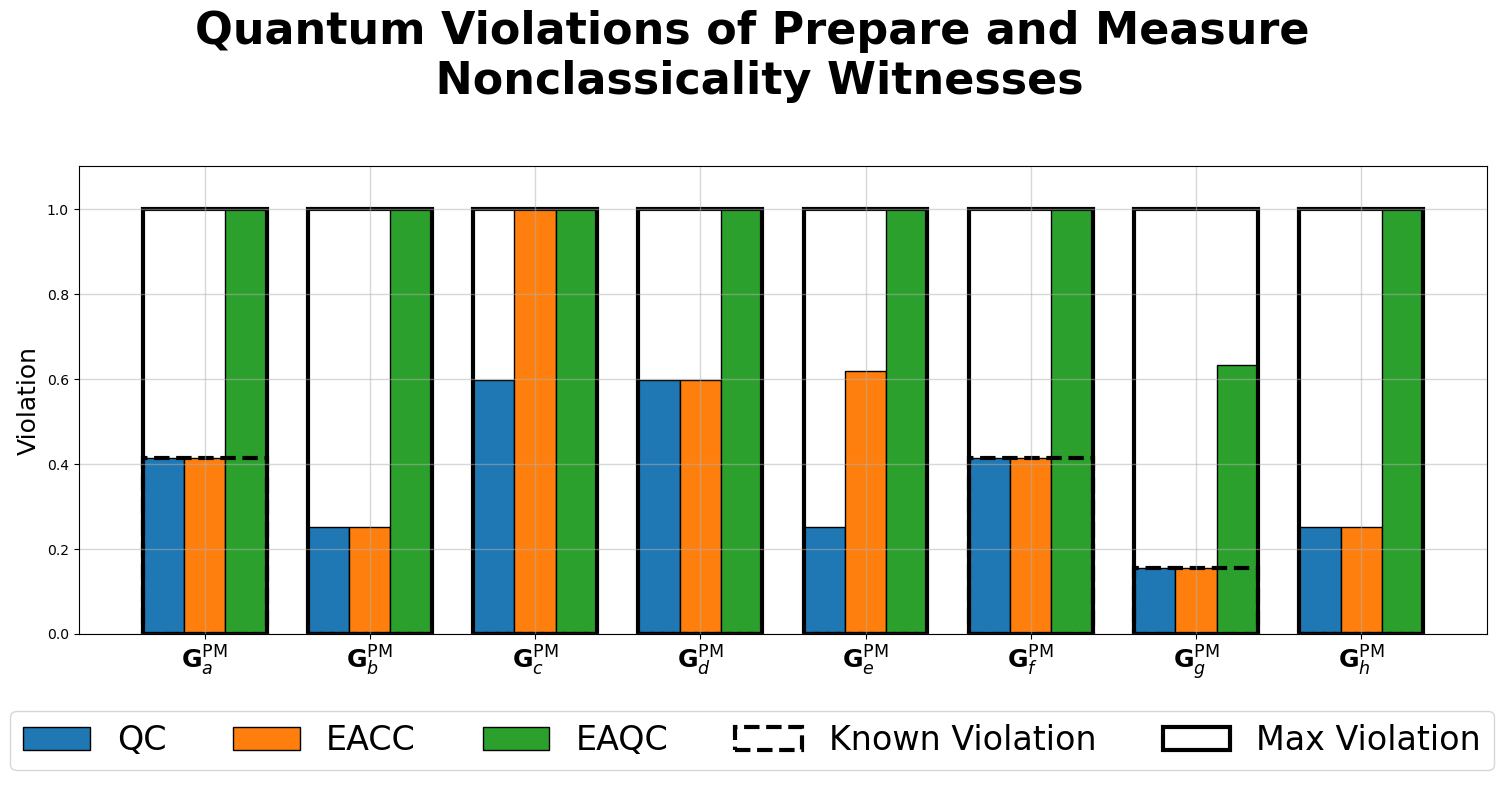

In [30]:
x_axis = np.arange(8)
x_labels = [
    r"$\mathbf{G}_a^{\rm{PM}}$",
    r"$\mathbf{G}_b^{\rm{PM}}$",
    r"$\mathbf{G}_c^{\rm{PM}}$",
    r"$\mathbf{G}_d^{\rm{PM}}$",
    r"$\mathbf{G}_e^{\rm{PM}}$",
    r"$\mathbf{G}_f^{\rm{PM}}$",
    r"$\mathbf{G}_g^{\rm{PM}}$",
    r"$\mathbf{G}_h^{\rm{PM}}$",
]
known_violations = [
    (3 + np.sqrt(2) - 4) / (5 - 4),
    0,
    0,
    0,
    0,
    (4 + 2*np.sqrt(2) - 6)/(8 - 6),
    (0.5*(1 + 1/np.sqrt(3)) * 24 - 18)/ (24-18),
    0,
]
width = 1/4

fig, ax1 = plt.subplots(figsize=(15, 8), ncols=1,nrows=1)
ax1.grid(linewidth=1, alpha=0.5)


ax1.bar(x_axis-1*width, qc_arb_max_violations, width=width, label="QC", edgecolor="black",linewidth=1)
ax1.bar(x_axis+0*width, eacc_arb_max_violations, width=width, label="EACC", edgecolor="black",linewidth=1)
ax1.bar(x_axis+1*width, eaqc_arb_max_violations, width=width, label="EAQC", edgecolor="black",linewidth=1)



plt.bar(x_axis+0*width, known_violations, width=1-width,  label="Known Violation", edgecolor="black", linewidth=3, fill=False, linestyle="--")



plt.bar(x_axis+0*width, [1]*len(pm_inequalities), width=1-width,  label="Max Violation", edgecolor="black", linewidth=3, fill=False)


ax1.set_xticks(x_axis, x_labels, fontsize=18)
# ax1.set_yticks(fontsize=24)
ax1.set_ylabel("Violation", fontsize=18)

# ax2.set_yticks(fontsize=24)

# ax2.set_ylabel("Violation", fontsize=24)

fig.suptitle("Quantum Violations of Prepare and Measure\n Nonclassicality Witnesses\n", size=32, fontweight="bold")


ax1.set_ylim([0,1.1])
plt.figlegend(loc="lower center", ncols = 5, fontsize=24)

# plt.legend(fontsize=20, ncol=3)
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)

plt.show()